Story of why I did what I did

I wanted to calculate MoI from the period of ossilation, mass, and centre of mass.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import hilbert, chirp

Lets input in the data I measured

In [2]:
prostheses = ['A','B','C','D','E','F','G','H','adaptor']
data_in = {'Combined Mass':[1860,2106,1677,2670,2925,1615,2767,2444,275],
    'CoM mass side':[205,325,220,209,726,247,469,411,12.2],
    'CoM mass length':[775,952,686,947,1039,831,1192,1239,59],
    'PoR-Origin side':[70,152,109,-23,193,90,167,100,27],
    'PoR-Origin length':[573,610,527,410,435,554,593,612,121],
    'Period of Osc':[1.41,1.44,1.34,1.16,1.22,1.29,1.38,1.37,0.68]}
measured_data = pd.DataFrame(data_in)
measured_data

,Combined Mass,CoM mass side,CoM mass length,PoR-Origin side,PoR-Origin length,Period of Osc
0,1860,205.0,775,70,573,1.41
1,2106,325.0,952,152,610,1.44
2,1677,220.0,686,109,527,1.34
3,2670,209.0,947,-23,410,1.16
4,2925,726.0,1039,193,435,1.22
5,1615,247.0,831,90,554,1.29
6,2767,469.0,1192,167,593,1.38
7,2444,411.0,1239,100,612,1.37
8,275,12.2,59,27,121,0.68


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import hilbert, chirp

df_1 = pd.read_csv('data/Trajectories_weight1_largerangles.csv')
df_2 = pd.read_csv('data/Trajectories_weight1_smallerangles.csv')
df_3 = pd.read_csv('data/Trajectories_weight2.csv')
df_4 = pd.read_csv('data/Trajectories_weight3.csv')
df_5 = pd.read_csv('data/Trajectories_weight4.csv')

df_x_traj = pd.DataFrame().assign(Weight_4=df_5['trajX3'], Weight_1_Large=df_1['trajX0'], Weight_1_Short=df_2['trajX3'], Weight_2=df_3['trajX3'], Weight_3=df_4['trajX2'])



In [4]:
for col in df_x_traj:
    #translate plots to ossilate around x = 0
    #plots get envelope points
    df_x_traj[col] -= df_x_traj[col].mean()

In [33]:
cols = []
damping_factors = []
angular_freqs = []
natural_ang_freqs = []
for col in df_x_traj:
    
    cols.append(col)
    
    peaks = signal.find_peaks(df_x_traj[col],height=0,distance=20)
    
    #calculate the damping factor
    index_of_peak1 = peaks[0][0]
    index_of_5th_last_peak = peaks[0][-5]
    first_peak_amplitude = df_x_traj[col][index_of_peak1]
    fith_last_peak_amplitude = df_x_traj[col][index_of_5th_last_peak]
    ratio_of_amplitudes = np.arcsin(first_peak_amplitude/650)/np.arcsin(fith_last_peak_amplitude/650) #in angular position, radians (the length from marker to pivot was ~650mm & trajs are in mm)
    t = (index_of_5th_last_peak - index_of_peak1)/100 #1/100 time intervals
    natural_log_of_RoA = np.log(ratio_of_amplitudes) #in Numpy log(exp(x)) = x 
    damping_factor = (-2*natural_log_of_RoA)/t
    damping_factors.append(damping_factor)
    
    #calculate the measured angular frequency (radians/s)
    indexs_of_peaks = peaks[0][:-5] #last few can be a bit noisy, hence why the -5
    diffs = np.diff(indexs_of_peaks)
    period_of_oss = (diffs).mean()/100 #100hz
    angular_freq=2*np.pi*(1/period_of_oss)
    angular_freqs.append(angular_freq)
    
    #calculate the natural anglular frequency (formula according to Newtonian Mechanics)
    natural_ang_freq = ((angular_freq**2) + ((damping_factor/2)**2))**0.5
    natural_ang_freqs.append(natural_ang_freq)
    
results = pd.DataFrame(data={'Damping Factor':damping_factors, 'Frequency':angular_freqs, 'Natural Frequency':natural_ang_freqs}, index=cols)
results['Period of Oss w0']=(2*np.pi)/(results['Natural Frequency'])
results['Period of Oss p']=(2*np.pi)/(results['Frequency'])
results['% Diff']=100*(results['Period of Oss p']-results['Period of Oss w0'])/results['Period of Oss p']
results

,Damping Factor,Frequency,Natural Frequency,Period of Oss w0,Period of Oss p,% Diff
Weight_4,-0.009715,4.546119,4.546121,1.382098,1.382099,0.000057
Weight_1_Large,-0.041409,4.604472,4.604518,1.364570,1.364583,0.001011
Weight_1_Short,-0.119696,4.645036,4.645421,1.352554,1.352667,0.008299
Weight_2,-0.019660,4.573079,4.573090,1.373947,1.373951,0.000231
Weight_3,-0.016748,4.570205,4.570213,1.374813,1.374815,0.000168


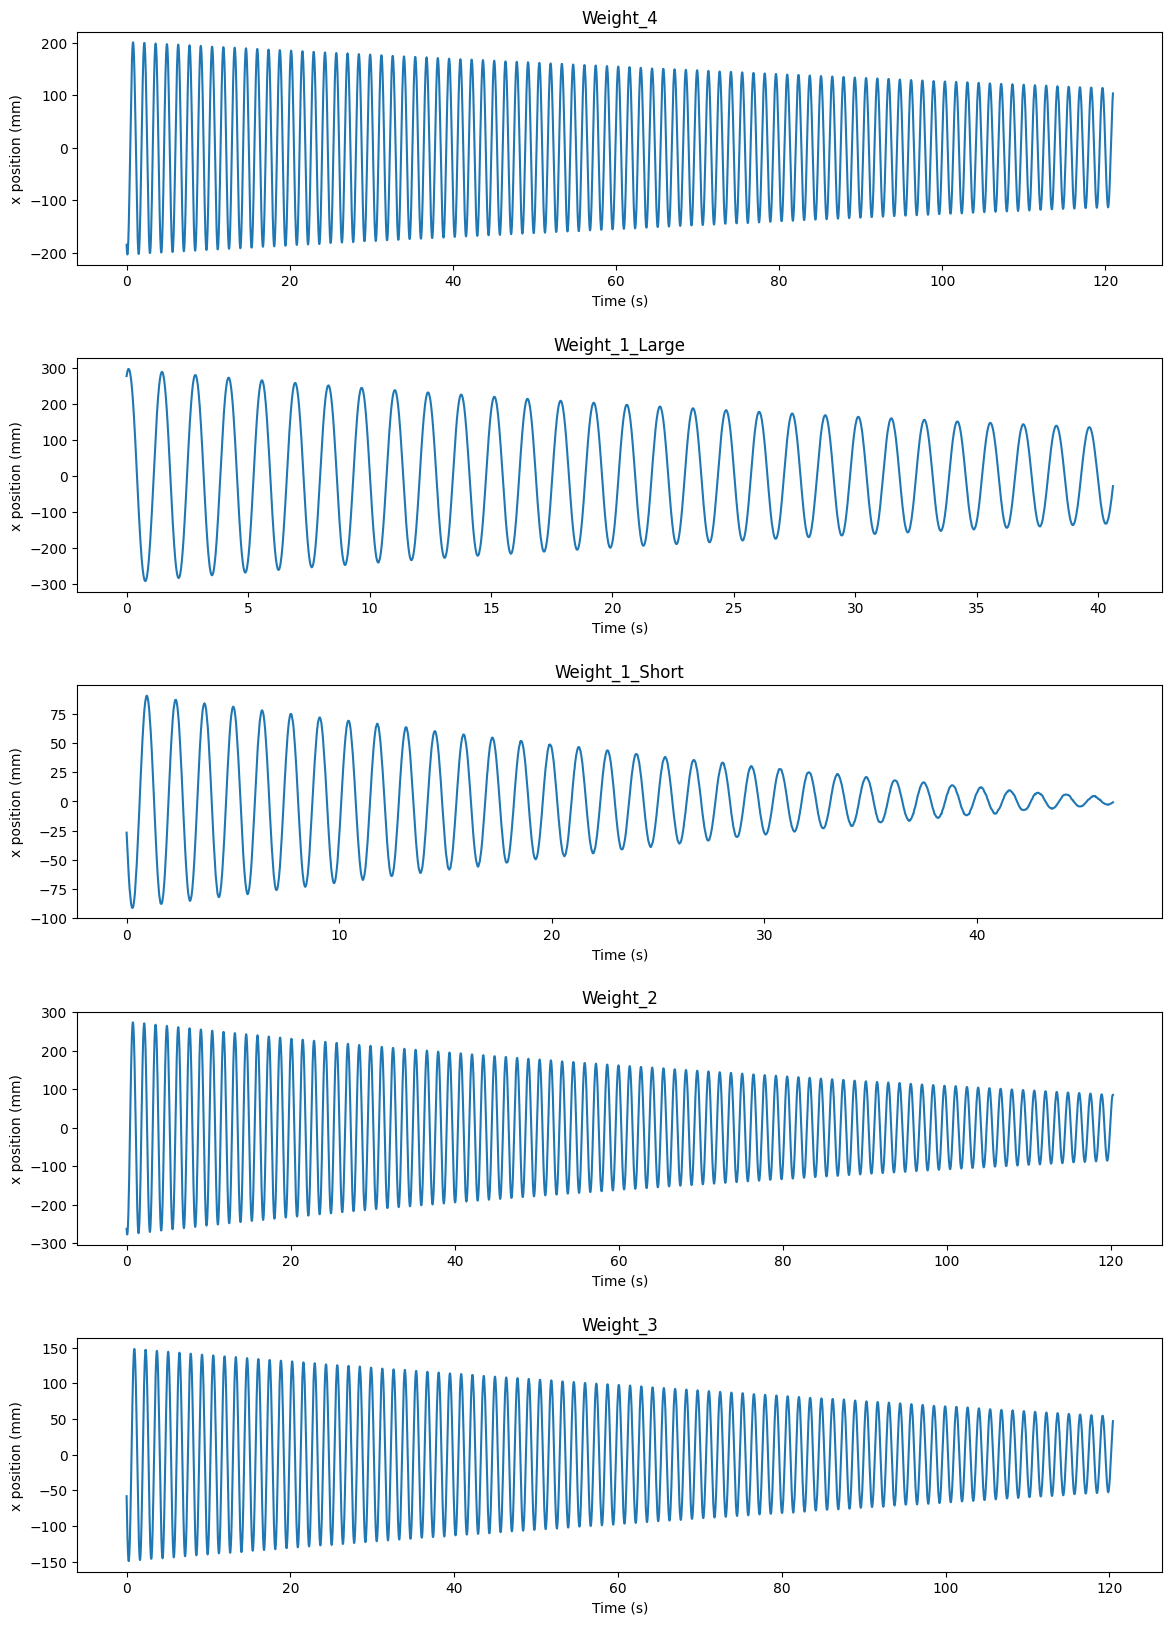

In [6]:
#Create plots for each recording
fig, ax = plt.subplots(5, 1, figsize=(14,20))
fig.subplots_adjust(hspace=0.4)
n=0
for col in df_x_traj:
    #plots get envelope points
    upper_env = np.abs(hilbert(df_x_traj[col]))
    lower_env = -np.abs(hilbert(-df_x_traj[col]))
    #get time points
    t = df_x_traj[col].index *0.01
    ax[n].set_title(col)
    ax[n].set_xlabel('Time (s)')
    ax[n].set_ylabel('x position (mm)')
    ax[n].plot(t, df_x_traj[col])
    #ax[n].legend()
    n+=1

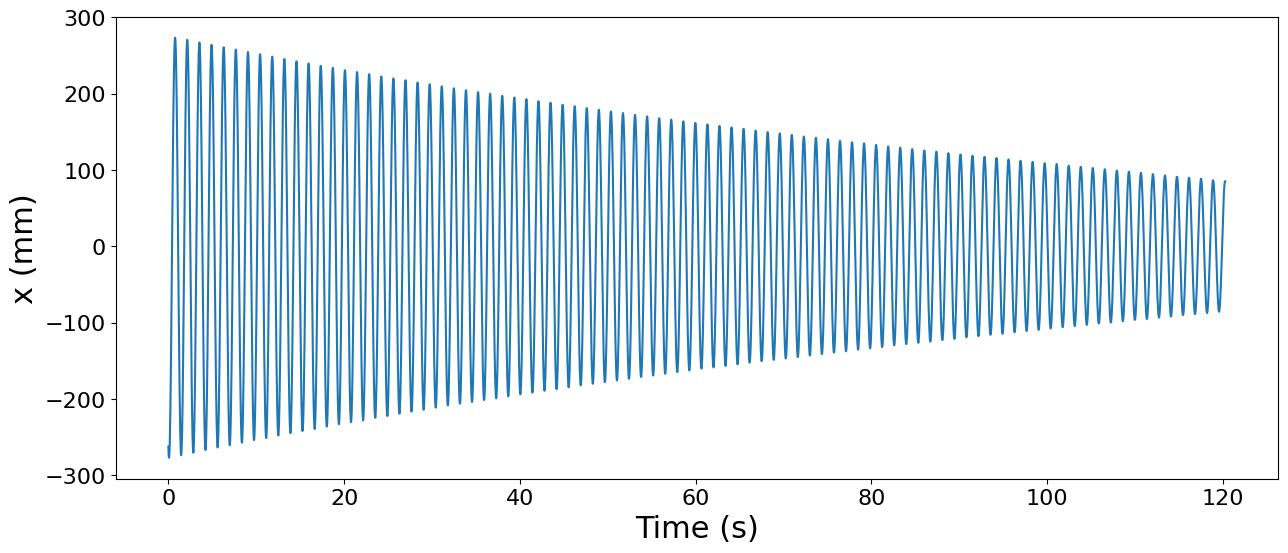

In [30]:
fig, ax = plt.subplots(figsize=(15,6))
t = df_x_traj['Weight_2'].index *0.01
ax.set_xlabel('Time (s)', fontsize=22)
ax.set_ylabel('x (mm)', fontsize=22)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=18)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=18)
ax.plot(t, df_x_traj['Weight_2'])
fig.savefig('Ref Damped Harmonic Motion.png')